# Schelling Model with Agents.jl

> Computational Analysis of Social Complexity



**Prerequisites**

- Julia Basics
- Julia Types
- ABM intro

**Outcomes**

- Implement the Schelling segregation model using Agents.jl

**References**

- [Agents.jl tutorial](https://juliadynamics.github.io/Agents.jl/stable/examples/schelling/#Schelling's-segregation-model)
- [QuantEcon lecture](https://julia.quantecon.org/multi_agent_models/schelling.html)

## Review Schelling Model

- Recall the components of the Schelling segregation model
- Environment: 25x25 grid of single family dwellings
- Agents with properties:
  - location (x,y) coordinate for current home
  - type: orange or blue. Fixed over time. 250 of each
  - happiness: 0 if less than $N$ of neighbors are of same type, 1 otherwise
- Rules:
  - Agents choose to move to unoccupied grid point if unhappy

> Note neighbors for a particular cell are the the 8 other cells surrounding the cell of interest. Corner or edge cells have less than 8 neighbors

## Agents.jl

- We are now ready to get started implementing the Schelling segregation model in Julia
- We'll use the Agents.jl library, which is a very powerful ABM toolkit
- Here are some points of comparison between Agents.jl and other ABM software (from the Agents.jl website):

![abm toolkits](https://compsosci-resources.s3.amazonaws.com/abm/abm_toolkit_comparison.png)

![toolkit features](https://compsosci-resources.s3.amazonaws.com/abm/abm_table1.png)

![toolkit features](https://compsosci-resources.s3.amazonaws.com/abm/abm_table2.png)

## Schelling in Agents.jl

- Let's now implement the Schelling Segregation model in Agents.jl
- The first thing we'll need to do is define our Agent
- The reccomended way to do this is to create a new Juila struct using the `@agent` macro provided by Agents.jl
- The macro will ensure a few things:
    - The struct contains `id` and `pos` fields to keep track of the agent and its position
    - The struct is mutable so the position can be updated
    - The struct is a subtype of `AbstractAgent` so it can be used by other functions in Agents.jl

In [1]:
# load up packages we need for this example... might take a few minutes
# import Pkg
# Pkg.activate(".")
# Pkg.instantiate()

using Agents

In [4]:
@agent struct SchellingAgent(GridAgent{2})
    is_happy::Bool      # whether the agent is happy in its position. (true = happy)
    group::Int          # The group of the agent, determines mood as it interacts with neighbors 0: blue, 1: orange
end

- We can see the complete structure of the `ShellingAgent` type using the `dump` function

In [5]:
dump(SchellingAgent)

SchellingAgent <: AbstractAgent
  id::Int64
  pos::Tuple{Int64, Int64}
  is_happy::Bool
  group::Int64


### Schelling Environment

- Our Schelling environment will be one the built-in Agents.jl spaces
- We'll use `GridSpace`

In [6]:
environment = GridSpaceSingle((25, 25); periodic = false)

GridSpaceSingle with size (25, 25), metric=chebyshev, periodic=false

### Rules

- The last part of our ABM that we need to specify is the rules for how agents respond to the environment and state
  - Our rule is that agents will choose to move to an empty grid space if they have less than `wanted_neighbors` neighbors of the same group
- Agents.jl requires us to implement these rules in a method `agent_step!(agent::SchellingAgent, model)`
- We'll make use of a couple helper functions provided by Agents.jl:
  - `move_agent_single!`: move a single agent to an empty place in the environment. This modifies the `pos` field of the agent
  - `nearby_agents`: return an array of all neighbors of a particular agent. This queries the `pos` field of all agents

In [8]:
function agent_step!(agent::SchellingAgent, model)
	want = model.wanted_neighbors
	have = 0
	for n in nearby_agents(agent, model)
		if n.group == agent.group
			have += 1
		end
	end
	agent.is_happy = have >= want
	if !agent.is_happy
		move_agent_single!(agent, model)
	end
	return
end

agent_step! (generic function with 1 method)

### Combining Agents, Environment, and Rules

- We now need to create an instance of the `AgentBasedModel` (or `ABM` for short) type
- To construct our instance we need to specify our agent type, our environment, our rules (via `agent_step!` function), and any additional properties
- These additional properties belong to the model, and can be thought of as parameters that should be calibrated
- In our previous exposition we would have attached these to the environment

In [22]:
properties = Dict(:wanted_neighbors => 4)
schelling = AgentBasedModel(SchellingAgent, environment; properties=properties, agent_step! = agent_step!)

StandardABM with 0 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (25, 25), metric=chebyshev, periodic=false
 scheduler: fastest
 properties: wanted_neighbors

### Add Agents

- Now we have fully specified the behavior of our ABM, but we have a problem...
- We don't have any agents!!
- To add agents, we'll use the `add_agent_single!(::SchellingAgent, model)` function, which is provided by Agents.jl and knows how to place non-overlapping agents in our environment
  - This will set the `pos` field for our agents
- So that we can run many experiements, we'll actually create a helper function that will create a new model from scratch and add agents to it

In [23]:
function init_schelling(;num_agents_per_group=250)
	environment = GridSpaceSingle((25, 25), periodic=false)
	properties = Dict(:wanted_neighbors => 4)
	model = ABM(SchellingAgent, environment; properties=properties, agent_step! = agent_step!)
	
	id = 0
	for group in 1:2, i in 1:num_agents_per_group
		agent = SchellingAgent(id+=1, (1, 1), false, group)
		add_agent_single!(agent, model)
	end
	model
end

model = init_schelling()

StandardABM with 500 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (25, 25), metric=chebyshev, periodic=false
 scheduler: fastest
 properties: wanted_neighbors

### Running the Model

- To run our model, we need to step forward in time
- We do this using the `step!` function provided by Agents.jl
- This function will iterate over all the agents in the model and call `agent_step!` for each of them

In [24]:
# advance one step
step!(model)

StandardABM with 500 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (25, 25), metric=chebyshev, periodic=false
 scheduler: fastest
 properties: wanted_neighbors

In [25]:
# advance three steps
step!(model, 3)

StandardABM with 500 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (25, 25), metric=chebyshev, periodic=false
 scheduler: fastest
 properties: wanted_neighbors

- We can also use the `run` function
- This function requires a model, agent_step! function, number of steps and array of agent property names to record
- The output is a DataFrame with all the data

In [26]:
model = init_schelling()
adata = [:pos, :is_happy, :group]  # short for agent data
data, _ = run!(model, 10; adata)
data

Row,time,id,pos,is_happy,group
,Int64,Int64,Tuple…,Bool,Int64
1,0,1,"(2, 1)",false,1
2,0,2,"(11, 20)",false,1
3,0,3,"(3, 22)",false,1
4,0,4,"(10, 21)",false,1
5,0,5,"(7, 16)",false,1
6,0,6,"(10, 10)",false,1
7,0,7,"(11, 19)",false,1
8,0,8,"(2, 7)",false,1
9,0,9,"(19, 21)",false,1


### Visualizing the Agents

- One of the more instructive (and fun!) parts of agent based modeling is visualizing the data
- To do this visualization we will use the `abmplot` function

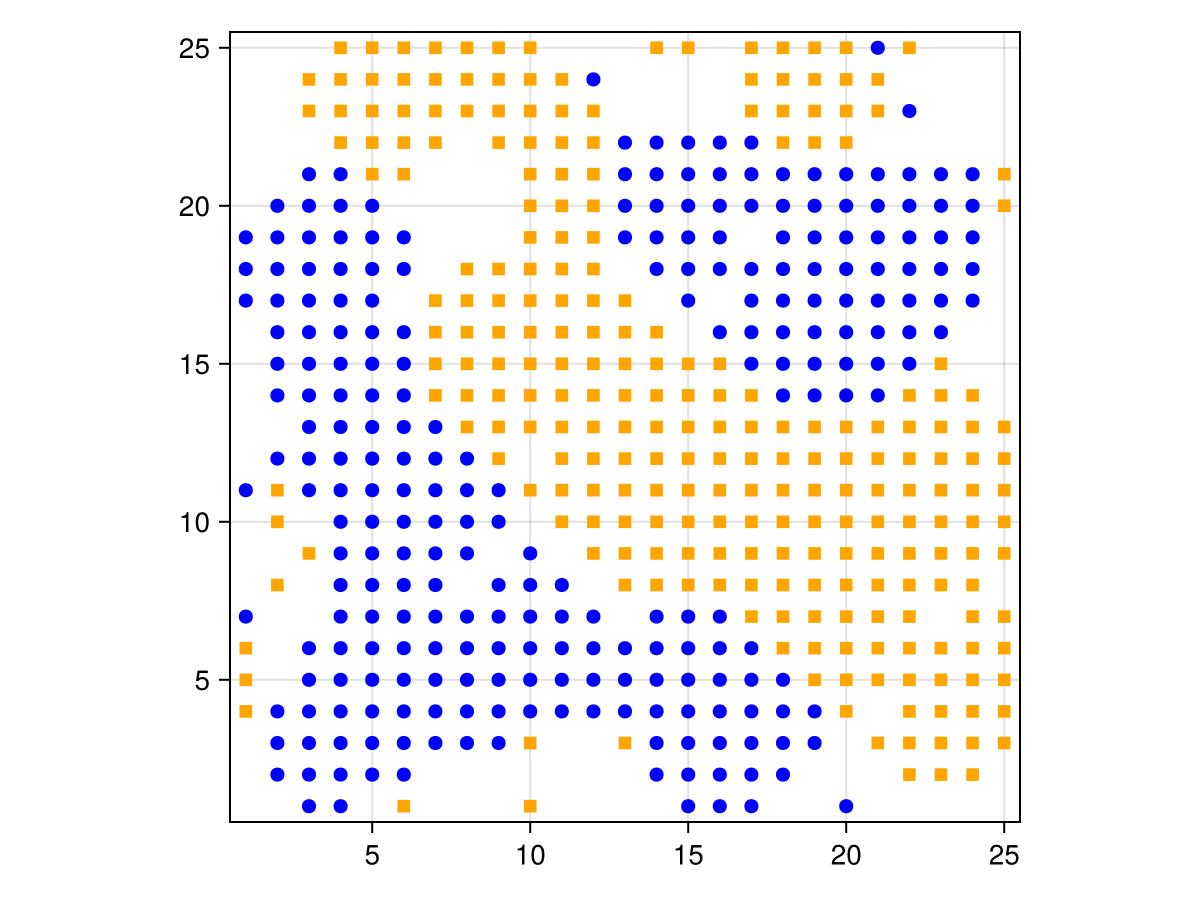

In [30]:
using CairoMakie

agent_color(a) = a.group == 1 ? :blue : :orange
agent_marker(a) = a.group == 1 ? :circle : :rect
figure, _ = abmplot(model; agent_color, agent_marker, agent_size = 10)
figure # returning the figure displays it

### Animating the Agents

- We can also create a video that animates our agents moving throughout the system
- We do this using the `abmvideo` function as follows

In [31]:
model = init_schelling();
abmvideo(
    "schelling.mp4", model;
    agent_color, agent_marker, agent_size = 10,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)

### Interactive Application

- Agents.jl also makes it very easy to create an interactive application for our model!
- We can do this using the `abmexploration` function
- This expects a single positional argument:
  - `model`
- We also have some keyword arguments
  - `params`: Dict mapping model parameters to range of values to test
  - `agent_color`, `agent_marker`, `agent_size`: control marker color color, symbol, and size as before
  - `adata`: Array of (agent_property, summary_func) tuples that specify which data to plot in separate charts
  - `alabels`: What label to put on the plots for `adata`

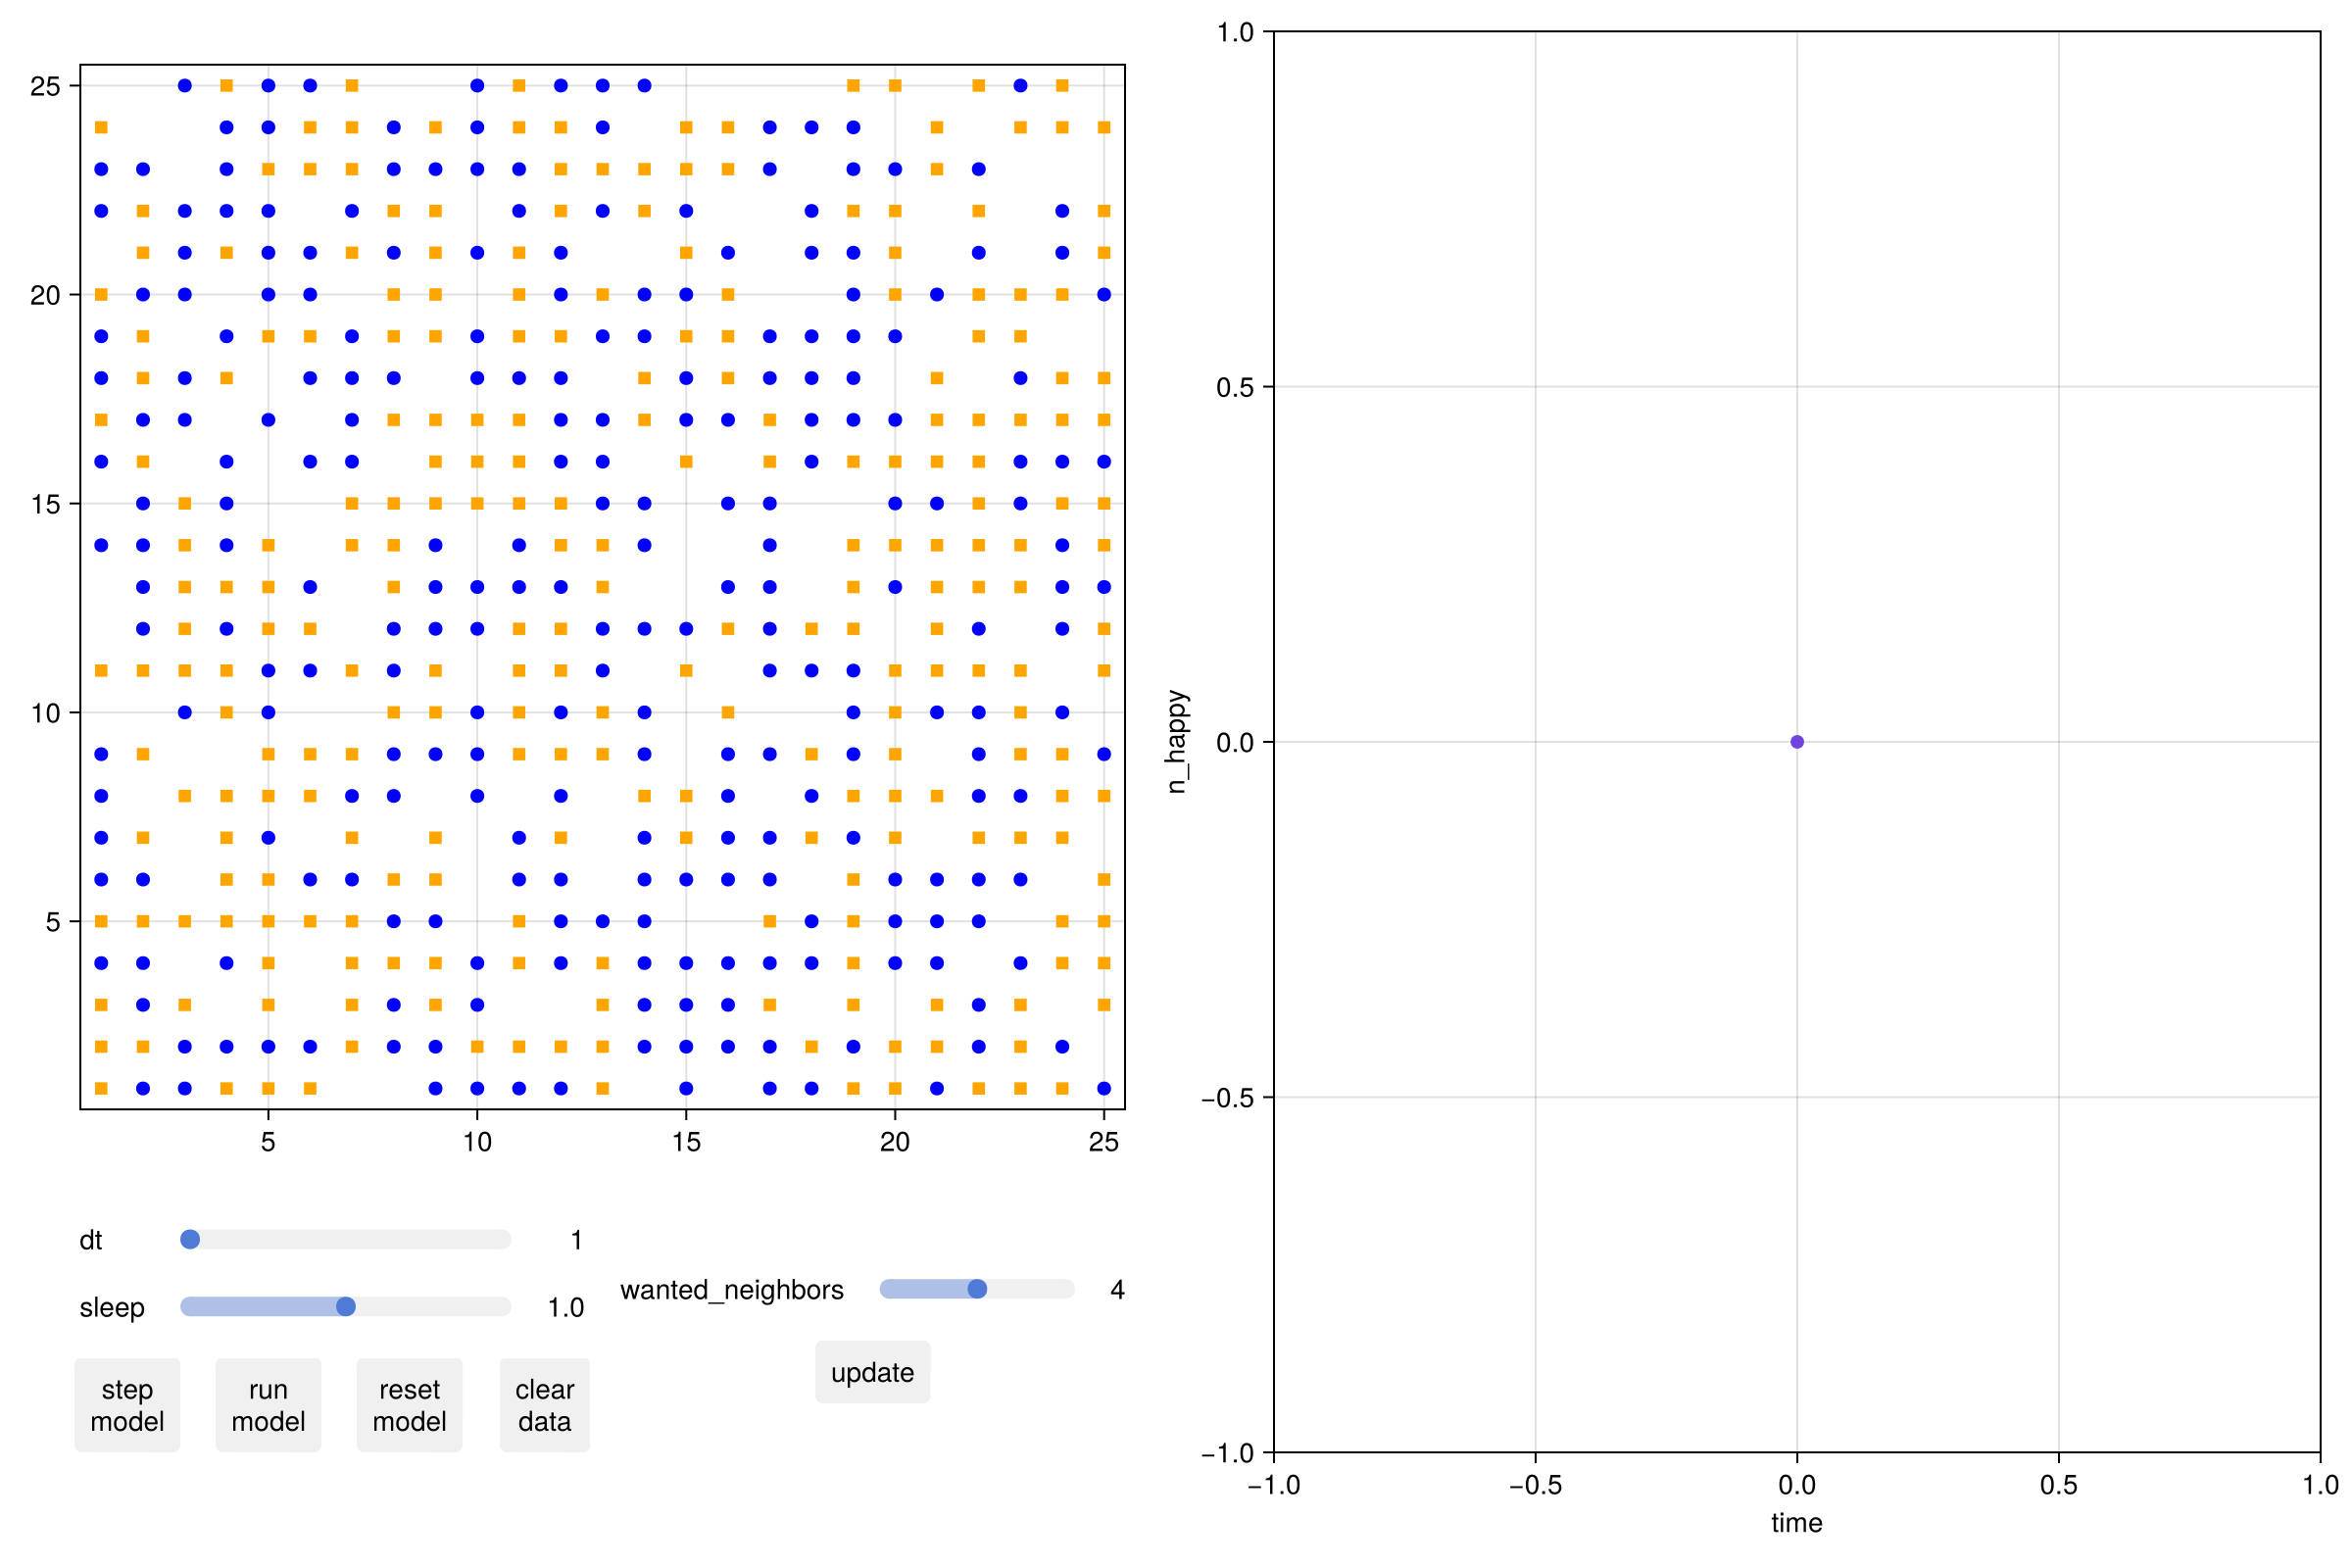

In [34]:
model = init_schelling()
adata = [(:is_happy, sum)]
alabels = ["n_happy"]
parameter_range = Dict(:wanted_neighbors => 0:8)
figure, abmobs = abmexploration(
    model;
    adata, alabels,
    agent_color, agent_marker, agent_size = 10,
    params=parameter_range,
)
figure

### Run from REPL

- In order to use the interactive app we need to run the code from the Julia REPL (not inside vs code or jupyter)
- We'll do that now